In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [9]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_column',500)
pd.set_option('display.width',1000)

path='https://covid.ourworldindata.org/data/ecdc/'
df = pd.read_csv(path+'full_data.csv')
ind = df[(df['location']=='India') & (df['date'] >='2020-03-15')].reset_index(drop=True).reset_index()
ind = ind.rename(columns={'index':'days'})
ind.tail()

,days,date,location,new_cases,new_deaths,total_cases,total_deaths
75,75,2020-05-29,India,7466,175,165799,4706
76,76,2020-05-30,India,7964,265,173763,4971
77,77,2020-05-31,India,8380,193,182143,5164
78,78,2020-06-01,India,8392,230,190535,5394
79,79,2020-06-02,India,8171,204,198706,5598


In [109]:
#Poly func:
def poly_func(x, *coefs):
    return sum([coefs[i] * x**i for i in range(len(coefs))])

In [248]:
class total_cases_model:
    def __init__(self, t_split):
        self.t_split = t_split
        
                
    def dashboard(self):    
        fig, axes = plt.subplots(2,2, figsize=(16,10))
        fig.subplots_adjust(hspace= 0.4)
        fig.suptitle('Dashboard')
        
        for ax,data,name in zip(axes.flatten(), ind.iloc[:,3:].values.T, ind.columns.values[3:]):
            f = ax.plot(ind.index.values,data)
            f = ax.set(title=name, xlabel='days')
        return f 
    
    def train_model(self):
         
        # extract X and Y data:
        x_data, y_data =(ind.index.values,ind['total_cases'].values)
        
        #Train and test split: self.t_split(e.g: 0.8 is 80% train and 20% test) 
        temp = np.random.random(len(ind)) < self.t_split
        train_x = x_data[temp]
        train_y = y_data[temp]
        test_x  = x_data[~temp]
        test_y  = y_data[~temp]
        
        #Train Model
        coefs, _   = curve_fit(poly_func, train_x, train_y, p0=np.ones(5))
        y_hat = poly_func(test_x,*coefs)
            
        #Evaluation:
        print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
        print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
        print("R2 Score: %.2f" % r2_score(y_hat,test_y))

        #Plot the Result
        plt.figure(figsize=(8,5))
        plt.plot(test_x,test_y,'ro', label='actual')
        plt.plot(test_x,y_hat,linewidth=3.0, label='fit')
        plt.title("Training Model")
        plt.legend(loc='best')
        plt.ylabel('cases')
        plt.xlabel('day')
        return coefs, _
    
          
    def predict(self):
        coefs, _ = self.train_model() 
        x_pred = np.arange(max(ind.days)+1,max(ind.days)+11)
        start_day = (pd.Timestamp(max(ind.date))+ pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        end_day   = (pd.Timestamp(max(ind.date))+ pd.DateOffset(days=11)).strftime('%Y-%m-%d')        
        day = np.arange(np.datetime64(start_day), np.datetime64(end_day))
        pred = poly_func(x_pred,*coefs)
        pred_df = pd.DataFrame({'day': x_pred, 'date':day, 'pred_total_cases':np.around(pred,decimals=0)}, index=x_pred )
        
        plt.figure(figsize=(8,5))
        pred_df.plot(x='date',y='pred_total_cases')
        plt.grid()
        plt.legend(loc='best')
        plt.title('Prediction of next 10 days')
        return plt.show(), pred_df
    

Mean absolute error: 483.77
Residual sum of squares (MSE): 354159.67
R2 Score: 1.00


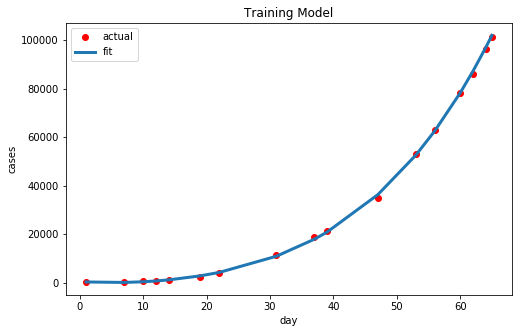

<Figure size 576x360 with 0 Axes>

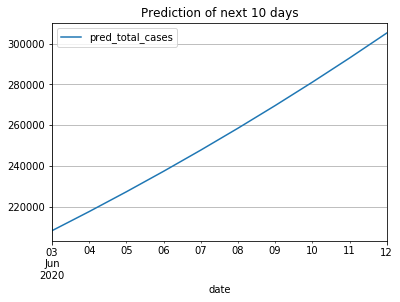

(None,     day       date  pred_total_cases
 80   80 2020-06-03          208390.0
 81   81 2020-06-04          217759.0
 82   82 2020-06-05          227454.0
 83   83 2020-06-06          237486.0
 84   84 2020-06-07          247861.0
 85   85 2020-06-08          258589.0
 86   86 2020-06-09          269678.0
 87   87 2020-06-10          281136.0
 88   88 2020-06-11          292972.0
 89   89 2020-06-12          305195.0)

In [249]:
c = total_cases_model(0.8)
c.predict()